In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import pymongo
import os

In [7]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [8]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

chapinero = apartments.loc[apartments['localidad'] == 'CHAPINERO']
chapinero.head()

codigo tipo_propiedad tipo_operacion  precio_venta  area  habitaciones  \
89   3052285    APARTAMENTO          VENTA   381000000.0  47.0           2.0   
107  3149085    APARTAMENTO          VENTA   481800000.0  70.0           2.0   
144  3607962    APARTAMENTO          VENTA   365300000.0  75.0           3.0   
178  3084633    APARTAMENTO          VENTA   376785000.0  31.0           1.0   
186  3327293    APARTAMENTO          VENTA   390000000.0  58.0           1.0   

     banos  administracion  parqueaderos       sector  ...  vigilancia  \
89     1.0        438000.0           1.0   CHICO LAGO  ...           0   
107    2.0             NaN           1.0   CHICO LAGO  ...           0   
144    2.0        325000.0           0.0    CHAPINERO  ...           0   
178    1.0        364601.0           1.0   CHICO LAGO  ...           0   
186    1.0        518300.0           1.0  PARDO RUBIO  ...           0   

    coords_modified  localidad                       barrio  \
89            False  CHAPINERO  S.C. CHICO NORTE III SECTOR   
107           False  CHAPINERO             S.C. CHICO NORTE   
144           False  CHAPINERO       S.C. CHAPINERO CENTRAL   
178           False  CHAPINERO  S.C. CHICO NORTE III SECTOR   
186           False  CHAPINERO             S.C. PARDO RUBIO   

                estacion_tm_cercana distancia_estacion_tm_m  \
89         Calle 100 - Marketmedios                  901.98   
107                          Virrey                 1204.73   
144                        Calle 57                  368.19   
178        Calle 100 - Marketmedios                  202.66   
186  Calle 45 - American School Way                  668.67   

    is_cerca_estacion_tm                                     parque_cercano  \
89                     0              PARQUE ZONAL CANAL EL VIRREY EL CHICO   
107                    0             PARQUE VECINAL URBANIZACIÓN LA CABRERA   
144                    1                  PARQUE ZONAL GUSTAVO URIBE BOTERO   
178                    1  PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II ...   
186                    0  PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) EN...   

    distancia_parque_m is_cerca_parque  
89             1128.83               0  
107             506.70               0  
144            1661.16               0  
178             728.22               0  
186            1010.27               0  

[5 rows x 45 columns]

In [9]:
# apartments = pd.read_csv('../../data/processed/apartments.csv', low_memory=False)
# chapinero =  apartments[(apartments['tipo_operacion'] == 'VENTA') & (apartments['localidad'] == 'CHAPINERO') & (apartments['coords_modified'] == False)]
# chapinero = chapinero.drop(columns=['precio_arriendo'])
# chapinero.head()

In [10]:
chapinero.datetime = pd.to_datetime(chapinero.datetime)

In [11]:
chapinero.shape

(2767, 45)

In [12]:
chapinero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2767 entries, 89 to 12134
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   codigo                   2767 non-null   object        
 1   tipo_propiedad           2767 non-null   object        
 2   tipo_operacion           2767 non-null   object        
 3   precio_venta             2767 non-null   float64       
 4   area                     2767 non-null   float64       
 5   habitaciones             2767 non-null   float64       
 6   banos                    2767 non-null   float64       
 7   administracion           2525 non-null   float64       
 8   parqueaderos             2767 non-null   float64       
 9   sector                   2660 non-null   object        
 10  estrato                  2767 non-null   int64         
 11  antiguedad               2766 non-null   object        
 12  latitud                  2767 non-nul

In [13]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque'],
      dtype='object')

In [14]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

# Eliminar outliers

Eliminamos los precios que son outliers

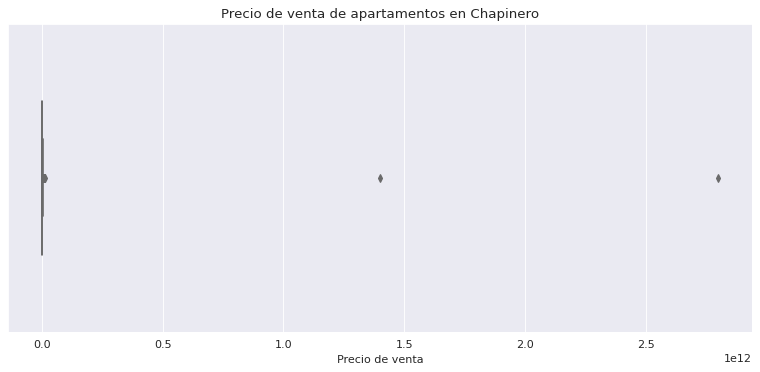

In [15]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    chapinero,
    x='precio_venta',
    width=.5,
    palette='Set3',
)

plt.title('Precio de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.show()

In [16]:
Q1 = chapinero['precio_venta'].quantile(0.25)
Q3 = chapinero['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
if lower < 0:
    lower = Q1 - (0.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = chapinero[(chapinero['precio_venta'] < lower) | (chapinero['precio_venta'] > upper)]
outliers.shape

(112, 45)

In [17]:
chapinero = chapinero[(chapinero['precio_venta'] > lower) & (chapinero['precio_venta'] < upper)]
chapinero.shape

(2655, 45)

# Analisis Univariado

## Area (m2)

### Eliminar outliers

In [18]:
# eliminar area igual a 0

chapinero = chapinero[chapinero['area'] > 0]

Eliminamos las areas (m2) que son outliers

In [19]:
Q1 = chapinero['area'].quantile(0.25)
Q3 = chapinero['area'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = chapinero[(chapinero['area'] < lower) | (chapinero['area'] > upper)]
outliers.shape

(32, 45)

In [20]:
chapinero = chapinero[(chapinero['area'] > lower) & (chapinero['area'] < upper)]
chapinero.shape

(2617, 45)

### Analisis

In [21]:
chapinero.area.describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

count                mean                std    min    25%    50%  \
area  2,617.0  183.73152464654186  92.97368398636893  17.36  110.0  173.0   

        75%    max  
area  248.0  450.0

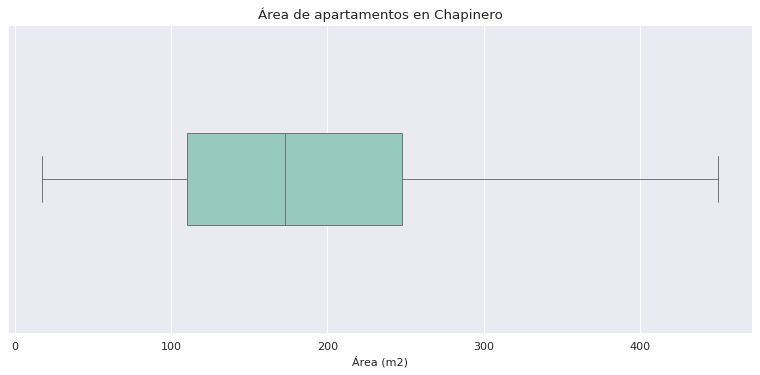

In [22]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=chapinero,
    x='area',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Área de apartamentos en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

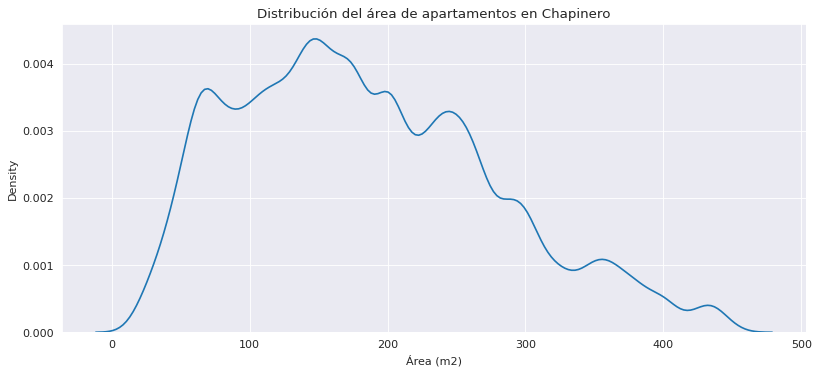

In [23]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
)

plt.title('Distribución del área de apartamentos en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

### Cercania a Transmilenio

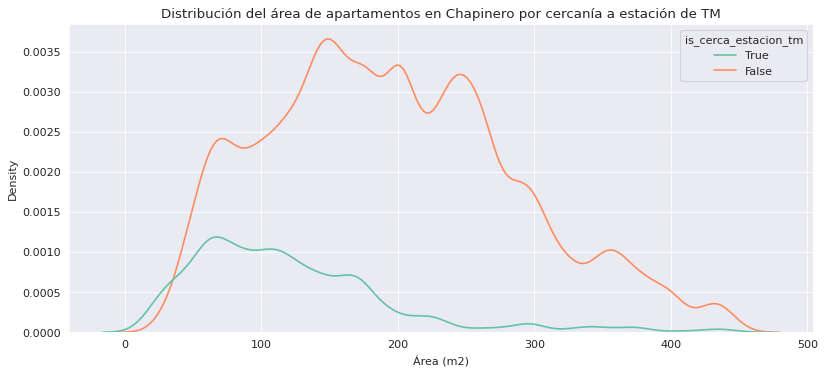

In [24]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('Distribución del área de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()

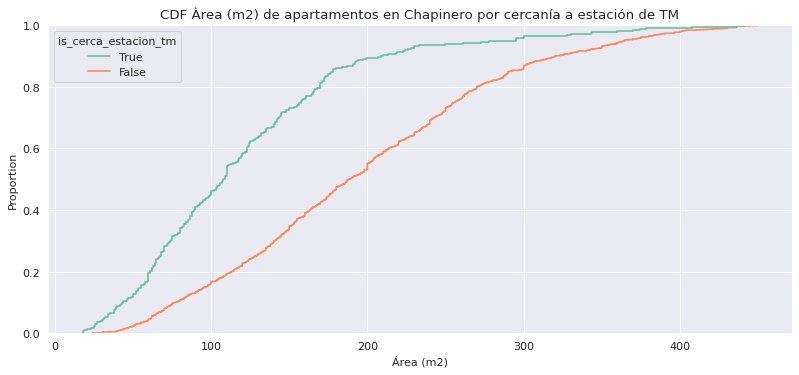

In [25]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('CDF Àrea (m2) de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()


### Estrato

In [26]:
chapinero.groupby('estrato')['area'].describe().applymap(lambda x: round(x, 1))

count   mean    std    min    25%    50%    75%    max
estrato                                                         
0           4.0  195.8  137.5  109.0  117.2  137.0  215.5  400.0
1           1.0  168.7    NaN  168.7  168.7  168.7  168.7  168.7
2           1.0   68.0    NaN   68.0   68.0   68.0   68.0   68.0
3          59.0   71.2   52.0   17.4   36.5   55.0   88.3  275.9
4         224.0   94.4   58.5   18.0   57.0   79.1  118.2  344.0
5         265.0  134.0   68.1   20.0   85.0  122.0  167.0  410.0
6        2063.0  203.1   89.3   18.0  138.0  197.0  261.0  450.0

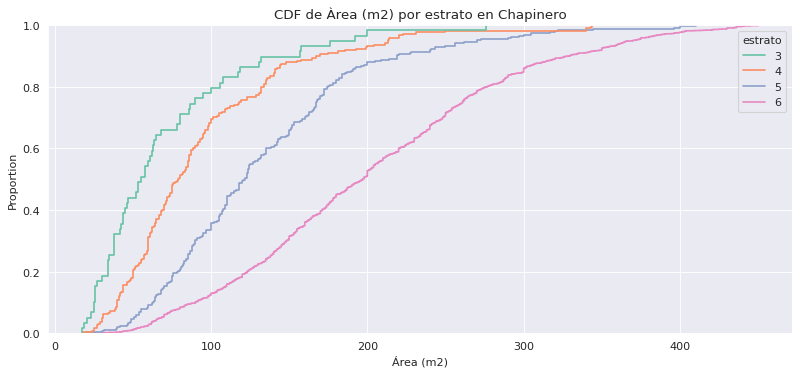

In [27]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='estrato',
    palette='Set2',
    hue_order=[3, 4, 5, 6],
)

plt.title('CDF de Àrea (m2) por estrato en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

### Antiguedad

In [28]:
chapinero.groupby('antiguedad')['area'].describe().applymap(lambda x: round(x, 1))

count   mean    std   min    25%    50%    75%    max
antiguedad                                                                
ENTRE 0 Y 5 ANOS     372.0  138.3   83.3  17.4   64.8  134.5  193.2  404.0
ENTRE 10 Y 20 ANOS   586.0  185.3   89.8  21.0  113.5  176.0  241.8  450.0
ENTRE 5 Y 10 ANOS    391.0  170.5   89.6  24.0   98.0  157.0  231.0  445.0
MAS DE 20 ANOS      1179.0  198.9   92.0  30.0  127.9  187.0  259.0  445.0
REMODELADO            88.0  220.0  105.7  51.1  140.2  217.0  284.5  450.0

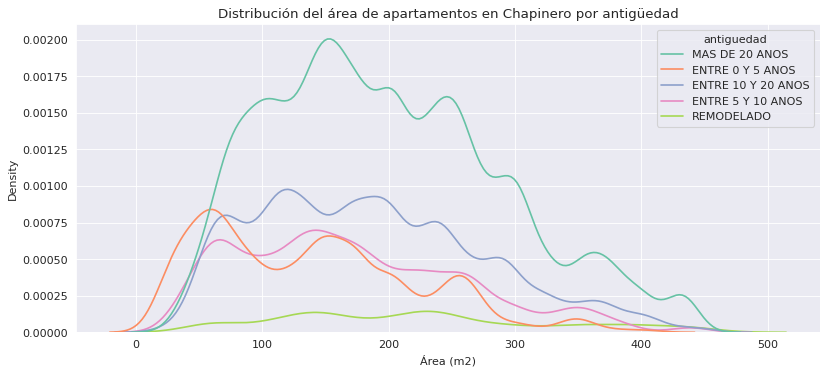

In [29]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Chapinero por antigüedad')
plt.xlabel('Área (m2)')
plt.show()

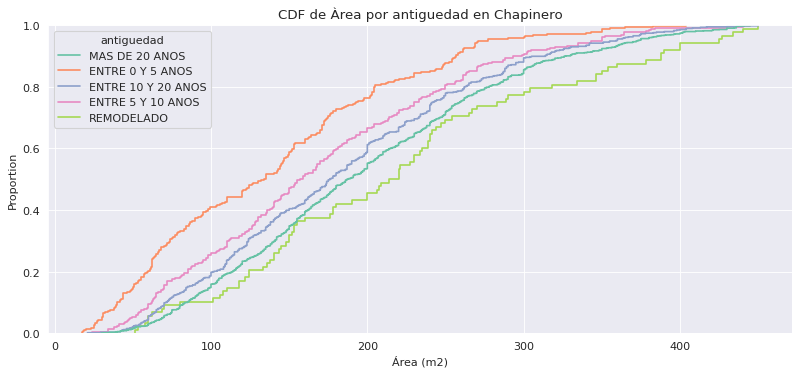

In [30]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de Àrea por antiguedad en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

Lo apartamentos mas recientes tienden a tener un Àrea menor que los mas antiguos

### Estacion de TM Cercana

In [31]:
estacion_tm_cercana = chapinero[chapinero['is_cerca_estacion_tm'] == True]
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='mean', ascending=False)
estacion_tm_cercana_stats

count   mean    std   min    25%    50%  \
estacion_tm_cercana                                                       
Héroes - Gel´Hada                10.0  238.3  128.0  49.0  126.8  250.6   
Virrey                           89.0  159.0   92.7  39.0   97.0  130.0   
Calle 85                         83.0  129.1   49.3  54.0   87.8  124.0   
Calle 100 - Marketmedios        130.0  120.6   66.3  18.0   70.0  110.5   
Calle 76 - San Felipe            16.0  111.6   58.3  46.0   79.0  104.5   
Calle 72                          5.0  100.4   62.9  61.0   66.7   73.0   
Calle 45 - American School Way   12.0   93.4   45.5  29.3   50.0  100.0   
Flores – Areandina               11.0   92.8   37.0  35.5   60.5  100.0   
Marly                            18.0   81.8   48.6  25.0   55.0   70.6   
Calle 63                         30.0   73.8   64.8  17.4   35.8   53.0   
Calle 57                         37.0   68.6   47.7  19.0   27.0   59.5   
AV. 39                            1.0   57.0    NaN  57.0   57.0   57.0   

                                  75%    max  
estacion_tm_cercana                           
Héroes - Gel´Hada               338.8  441.0  
Virrey                          199.0  434.4  
Calle 85                        166.7  344.0  
Calle 100 - Marketmedios        157.2  430.0  
Calle 76 - San Felipe           134.3  273.0  
Calle 72                         90.0  211.3  
Calle 45 - American School Way  121.5  175.0  
Flores – Areandina              125.5  140.0  
Marly                            92.8  223.0  
Calle 63                         87.8  343.0  
Calle 57                         86.6  192.0  
AV. 39                           57.0   57.0

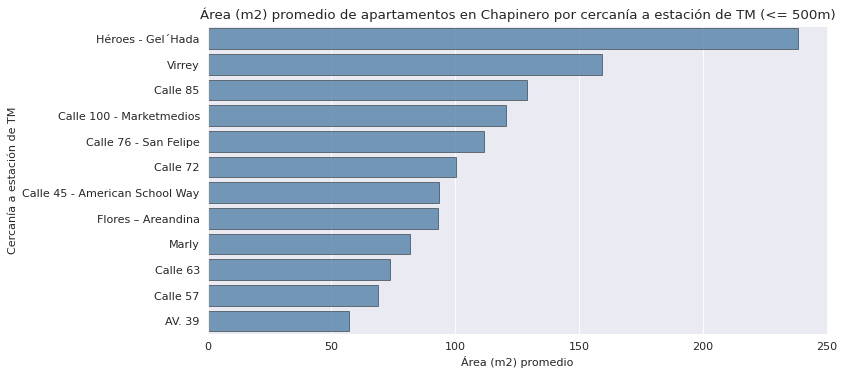

In [32]:
plt.figure(figsize=(10, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='mean',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) promedio de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) promedio')
plt.ylabel('Cercanía a estación de TM')
plt.show()

In [33]:
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='50%', ascending=False)

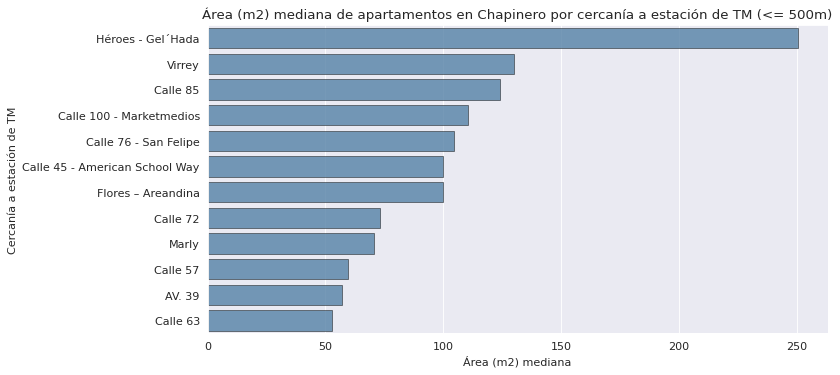

In [34]:
plt.figure(figsize=(10, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='50%',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) mediana de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) mediana')
plt.ylabel('Cercanía a estación de TM')
plt.show()

<Figure size 800x400 with 0 Axes>

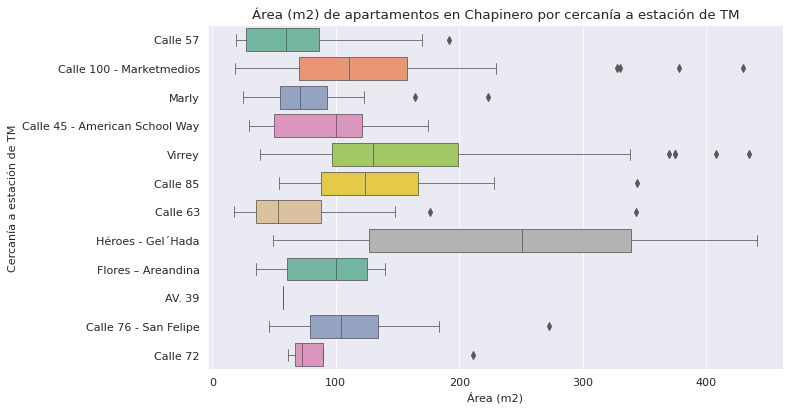

In [35]:
plt.figure(figsize=(10, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='area',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Área (m2) de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.ylabel('Cercanía a estación de TM')
plt.show()

## Precio de venta

In [37]:
fig = px.scatter_mapbox(
    chapinero,
    lat='latitud',
    lon='longitud',
    color='precio_venta',
    size='area',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    mapbox_style='open-street-map',
    # mapbox_style='dark',
    title='Precio de venta y área de apartamentos en Chapinero',
    hover_name='barrio',
    hover_data=['area', 'precio_venta', 'estrato', 'antiguedad', 'is_cerca_estacion_tm', 'estacion_tm_cercana'],
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title='Precio de venta',
        tickformat='s',
    ),
)

# save plot
fig.write_html('../../html/precio_venta_area_chapinero.html')

fig.show()

In [38]:
chapinero.precio_venta.describe().apply(lambda x: humanize.intword(x)).to_frame().T

count         mean            std            min  \
precio_venta  2.6 thousand  1.6 billion  992.0 million  180.0 million   

                        25%          50%          75%          max  
precio_venta  790.0 million  1.4 billion  2.2 billion  4.5 billion

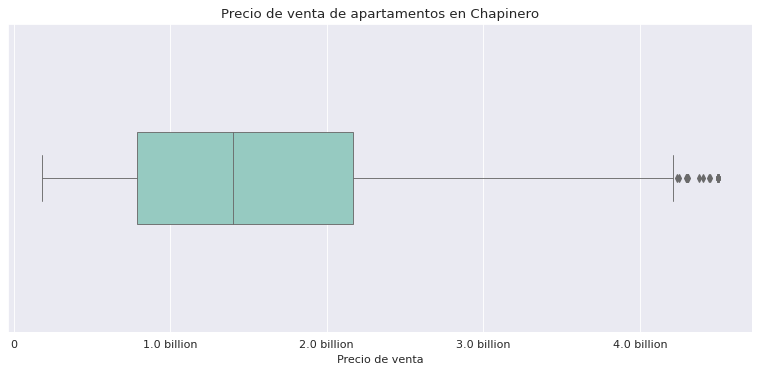

In [39]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    chapinero,
    x='precio_venta',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

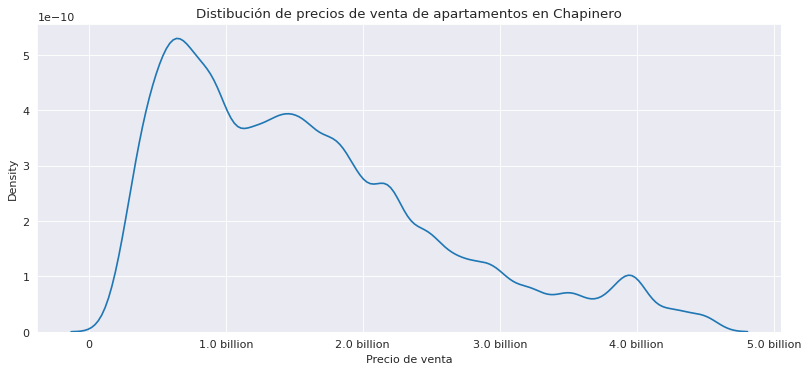

In [40]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [41]:
stat, p = stats.normaltest(chapinero['precio_venta'])
print('stat=%.3f, p=%.3f' % (stat, p))

stat=265.737, p=0.000


In [42]:
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Probably not Gaussian


### Barrios

In [43]:
top_barrios = chapinero.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

# escoger los que tienen más de 20 registros para que sea más representativo
top_barrios_mean = top_barrios[top_barrios['count'] > 22].sort_values('mean', ascending=False).head(10)
top_barrios_mean.applymap(lambda x: humanize.intword(x))

count         mean       median            std
barrio                                                                  
CHICO ORIENTAL               52  2.5 billion  2.4 billion    1.2 billion
LA CABRERA                  143  2.4 billion  2.2 billion  997.4 million
S.C. EL RETIRO               54  2.4 billion  2.2 billion    1.1 billion
CHICO ALTO                   40  2.2 billion  2.2 billion  699.0 million
BOSQUE EL RETIRO I SECTOR    63  2.1 billion  1.9 billion  965.7 million
S.C. LAS ACACIAS            102  1.9 billion  1.8 billion  853.6 million
S.C. EL CHICO               220  1.9 billion  1.7 billion    1.0 billion
S.C. BELLAVISTA             195  1.9 billion  1.7 billion  898.1 million
LOS ROSALES                 238  1.9 billion  1.7 billion  931.8 million
CHICO RESERVADO             105  1.7 billion  1.6 billion  887.5 million

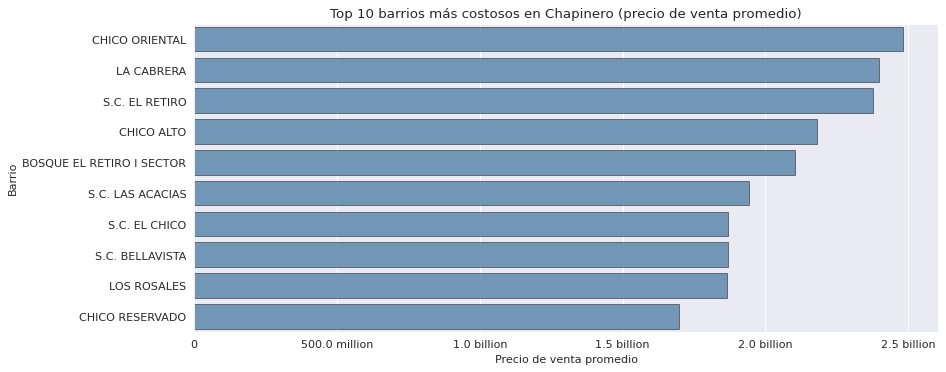

In [44]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_mean,
    y=top_barrios_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Chapinero (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [45]:
top_barrios_median = top_barrios[top_barrios['count'] > 22].sort_values('median', ascending=False).head(10)
top_barrios_median.applymap(lambda x: humanize.intword(x))

count         mean       median            std
barrio                                                                  
CHICO ORIENTAL               52  2.5 billion  2.4 billion    1.2 billion
LA CABRERA                  143  2.4 billion  2.2 billion  997.4 million
S.C. EL RETIRO               54  2.4 billion  2.2 billion    1.1 billion
CHICO ALTO                   40  2.2 billion  2.2 billion  699.0 million
BOSQUE EL RETIRO I SECTOR    63  2.1 billion  1.9 billion  965.7 million
S.C. LAS ACACIAS            102  1.9 billion  1.8 billion  853.6 million
S.C. BELLAVISTA             195  1.9 billion  1.7 billion  898.1 million
S.C. EL CHICO               220  1.9 billion  1.7 billion    1.0 billion
LOS ROSALES                 238  1.9 billion  1.7 billion  931.8 million
CHICO RESERVADO             105  1.7 billion  1.6 billion  887.5 million

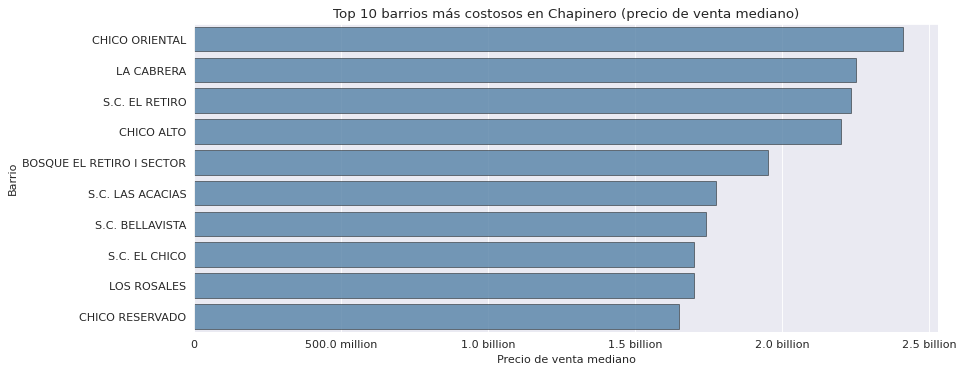

In [46]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_median,
    y=top_barrios_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Chapinero (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [47]:
top_barrios_economicos = chapinero.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

top_barrios_economicos_mean = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('mean', ascending=True).head(10)
top_barrios_economicos_mean.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                      
S.C. CHAPINERO CENTRAL       59  386.0 million  339.0 million  209.0 million
S.C. MARLY                   12  419.0 million  335.0 million  208.5 million
S.C. PARDO RUBIO             24  420.7 million  380.0 million  117.9 million
S.C. CHAPINERO NORTE         18  491.8 million  450.0 million  171.7 million
S.C. LA SALLE                15  523.3 million  460.0 million  198.8 million
S.C. BOSQUE CALDERON         33  528.0 million  470.0 million  249.0 million
S.C. MARIA CRISTINA          19  624.8 million  560.0 million  376.5 million
CHICO RESERVADO II SECTOR    24  756.7 million  695.0 million  316.8 million
S.C INGEMAR                  25  793.2 million  590.0 million  492.3 million
S.C. QUINTA CAMACHO          19  913.6 million  950.0 million  430.7 million

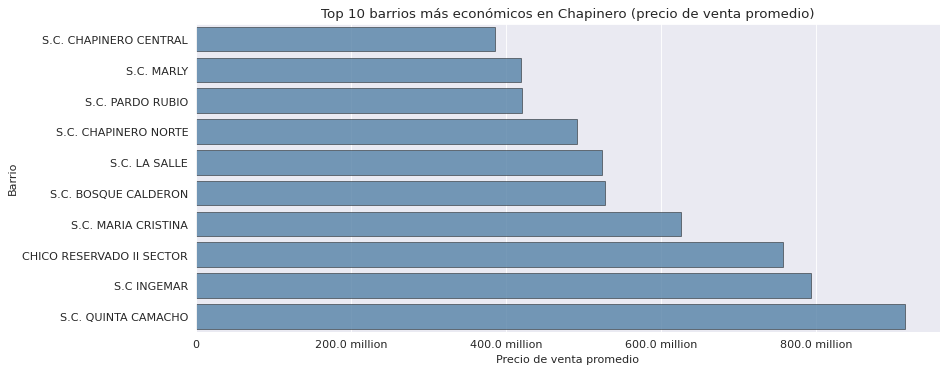

In [48]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_mean,
    y=top_barrios_economicos_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Chapinero (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [49]:
top_barrios_economicos_median = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('median', ascending=True).head(10)
top_barrios_economicos_median.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                      
S.C. MARLY                   12  419.0 million  335.0 million  208.5 million
S.C. CHAPINERO CENTRAL       59  386.0 million  339.0 million  209.0 million
S.C. PARDO RUBIO             24  420.7 million  380.0 million  117.9 million
S.C. CHAPINERO NORTE         18  491.8 million  450.0 million  171.7 million
S.C. LA SALLE                15  523.3 million  460.0 million  198.8 million
S.C. BOSQUE CALDERON         33  528.0 million  470.0 million  249.0 million
S.C. MARIA CRISTINA          19  624.8 million  560.0 million  376.5 million
S.C INGEMAR                  25  793.2 million  590.0 million  492.3 million
S.C. LAGO GAITAN             16    1.6 billion  640.0 million    1.4 billion
CHICO RESERVADO II SECTOR    24  756.7 million  695.0 million  316.8 million

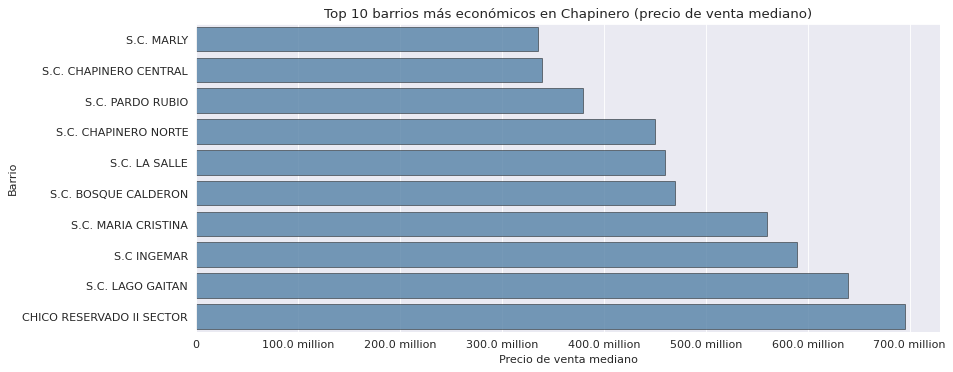

In [50]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_median,
    y=top_barrios_economicos_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Chapinero (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Cercania a Transmilenio

In [51]:
chapinero.groupby('is_cerca_estacion_tm')['precio_venta'].describe().applymap(lambda x: humanize.intcomma(x))

count                  mean                  std  \
is_cerca_estacion_tm                                                       
0                     2,175.0  1,726,092,560.964138  989,947,444.3728467   
1                       442.0   944,210,146.3755656  704,826,291.6261914   

                                min            25%              50%  \
is_cerca_estacion_tm                                                  
0                     220,000,000.0  927,500,000.0  1,580,000,000.0   
1                     180,000,000.0  490,000,000.0    727,000,000.0   

                                  75%              max  
is_cerca_estacion_tm                                    
0                     2,250,000,000.0  4,500,000,000.0  
1                     1,153,750,000.0  4,500,000,000.0

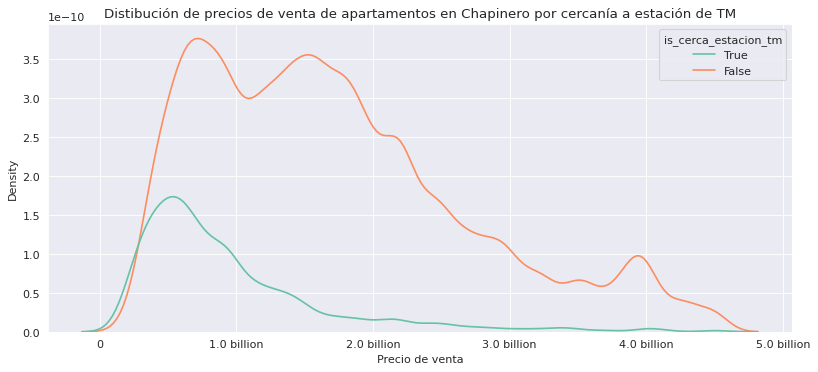

In [52]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

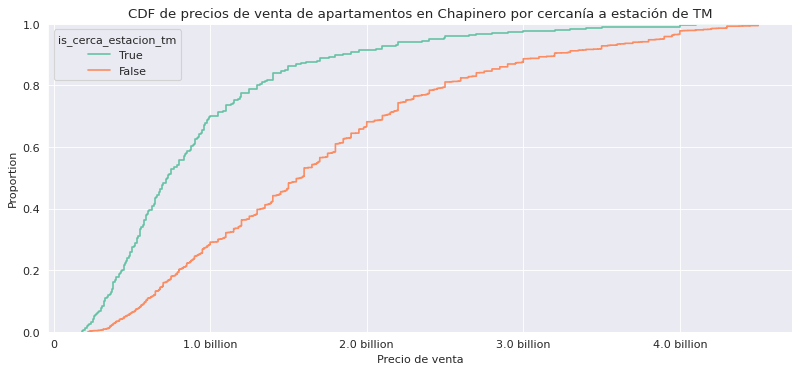

In [53]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estrato

In [54]:
chapinero.groupby('estrato')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))

count           mean            std            min  \
estrato                                                              
0                   4    1.8 billion    1.4 billion  660.0 million   
1                   1    1.4 billion            NaN    1.4 billion   
2                   1  380.0 million            NaN  380.0 million   
3                  59  420.7 million  289.8 million  190.0 million   
4                 224  631.8 million  470.7 million  180.0 million   
5                 265    1.1 billion  700.3 million  200.0 million   
6        2.1 thousand    1.8 billion  972.1 million  280.0 million   

                   25%            50%            75%            max  
estrato                                                              
0        772.5 million    1.3 billion    2.3 billion    3.8 billion  
1          1.4 billion    1.4 billion    1.4 billion    1.4 billion  
2        380.0 million  380.0 million  380.0 million  380.0 million  
3        262.5 million  349.9 million  450.0 million    1.8 billion  
4        378.7 million  492.5 million  662.5 million    2.9 billion  
5        650.0 million  910.0 million    1.4 billion    4.5 billion  
6          1.0 billion    1.6 billion    2.3 billion    4.5 billion

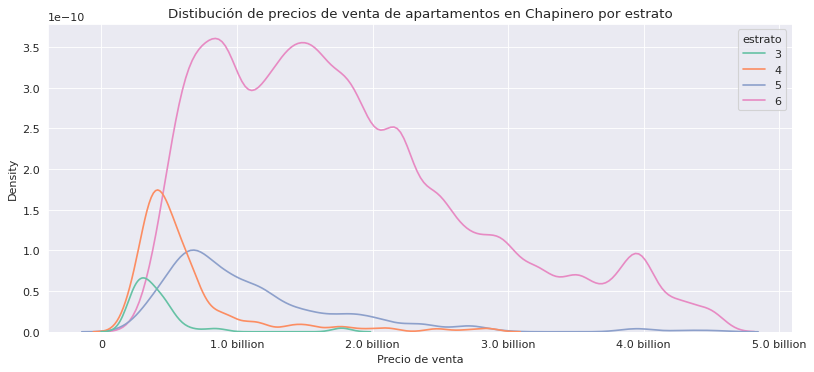

In [55]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[3, 4, 5, 6],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

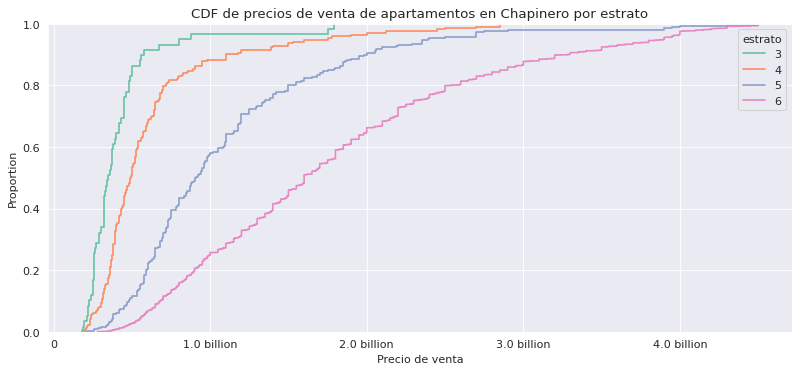

In [56]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='estrato',
    hue_order=[3, 4, 5, 6],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [57]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque'],
      dtype='object')

### Antiguedad del apartamento

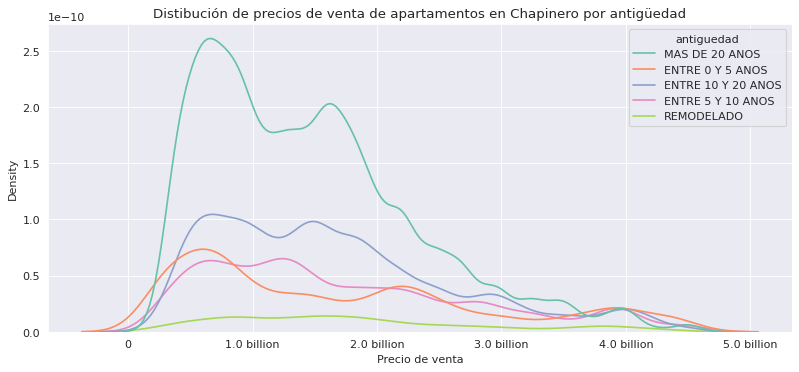

In [58]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

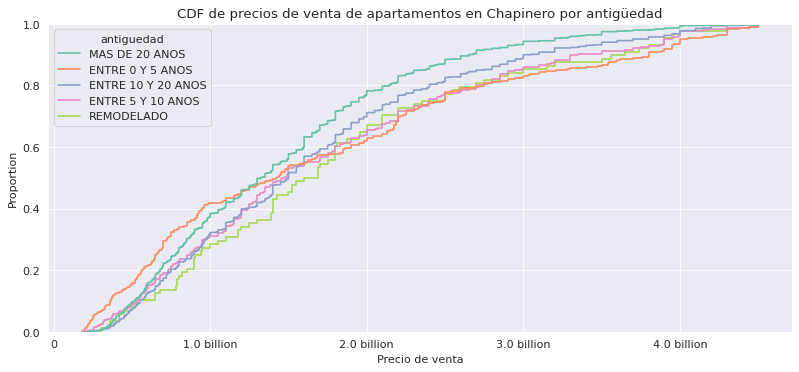

In [59]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estacion de TM Cercana

In [60]:
estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False).applymap(lambda x: humanize.intword(x))

count           mean            std  \
estacion_tm_cercana                                                  
Héroes - Gel´Hada                 10    2.2 billion    1.5 billion   
Virrey                            89    1.3 billion  776.2 million   
Calle 85                          83    1.2 billion  668.9 million   
Calle 100 - Marketmedios         130  923.6 million  540.2 million   
Calle 72                           5  776.2 million  367.4 million   
Calle 76 - San Felipe             16  715.9 million  404.1 million   
Flores – Areandina                11  503.3 million  121.2 million   
Calle 45 - American School Way    12  440.9 million  178.7 million   
Calle 63                          30  418.5 million  267.3 million   
Marly                             18  418.2 million  170.9 million   
Calle 57                          37  366.7 million  140.2 million   
AV. 39                             1  320.0 million            NaN   

                                          min            25%            50%  \
estacion_tm_cercana                                                           
Héroes - Gel´Hada               300.0 million  772.4 million    2.3 billion   
Virrey                          380.0 million  670.0 million  950.0 million   
Calle 85                        380.0 million  729.0 million    1.2 billion   
Calle 100 - Marketmedios        260.0 million  592.5 million  840.0 million   
Calle 72                        500.0 million  540.0 million  641.0 million   
Calle 76 - San Felipe           240.0 million  527.5 million  610.0 million   
Flores – Areandina              300.0 million  425.0 million  520.0 million   
Calle 45 - American School Way  180.0 million  322.5 million  430.7 million   
Calle 63                        210.0 million  271.2 million  364.0 million   
Marly                           198.5 million  312.5 million  380.0 million   
Calle 57                        190.0 million  260.0 million  339.0 million   
AV. 39                          320.0 million  320.0 million  320.0 million   

                                          75%            max  
estacion_tm_cercana                                           
Héroes - Gel´Hada                 3.5 billion    4.1 billion  
Virrey                            1.7 billion    3.4 billion  
Calle 85                          1.5 billion    4.5 billion  
Calle 100 - Marketmedios          1.1 billion    4.0 billion  
Calle 72                        800.0 million    1.4 billion  
Calle 76 - San Felipe           800.0 million    1.8 billion  
Flores – Areandina              588.0 million  720.0 million  
Calle 45 - American School Way  530.0 million  790.0 million  
Calle 63                        449.8 million    1.6 billion  
Marly                           457.5 million  950.0 million  
Calle 57                        430.0 million  800.0 million  
AV. 39                          320.0 million  320.0 million

In [61]:
estacion_tm_cercana_stats_mean = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False)
estacion_tm_cercana_stats_median = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('50%', ascending=False)

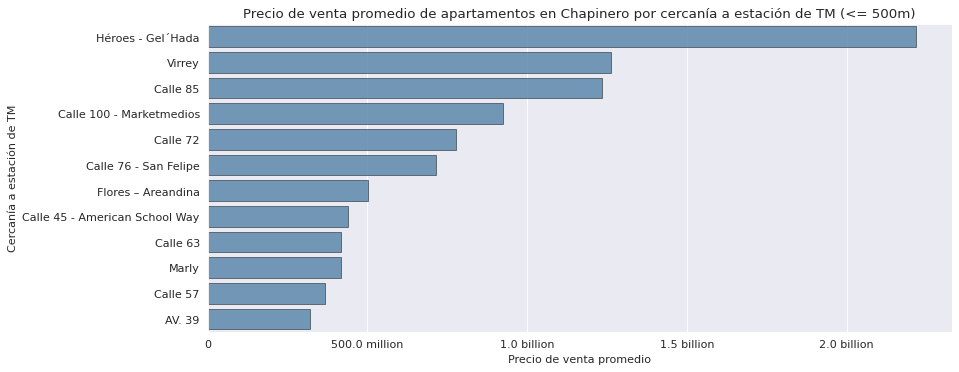

In [62]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_mean,
    y=estacion_tm_cercana_stats_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

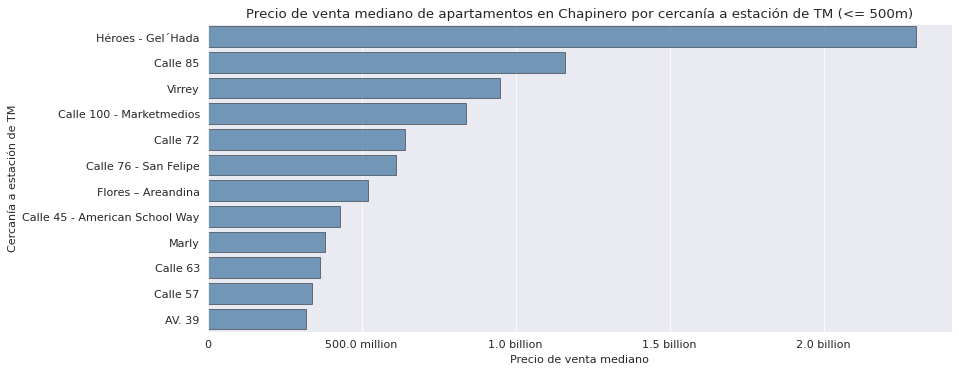

In [63]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_median,
    y=estacion_tm_cercana_stats_median.index,
    x='50%',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta mediano de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

<Figure size 960x400 with 0 Axes>

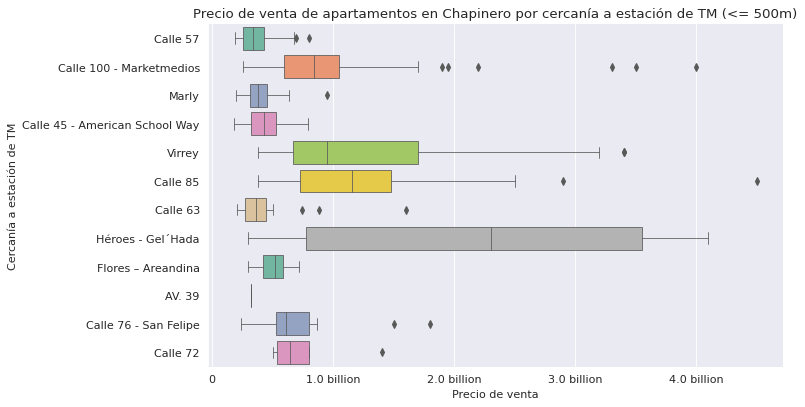

In [64]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='precio_venta',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Precio de venta de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Precios Anteriores Vs Actuales

## Antiguedad

In [65]:
chapinero.antiguedad.value_counts()

antiguedad
MAS DE 20 ANOS        1179
ENTRE 10 Y 20 ANOS     586
ENTRE 5 Y 10 ANOS      391
ENTRE 0 Y 5 ANOS       372
REMODELADO              88
Name: count, dtype: int64

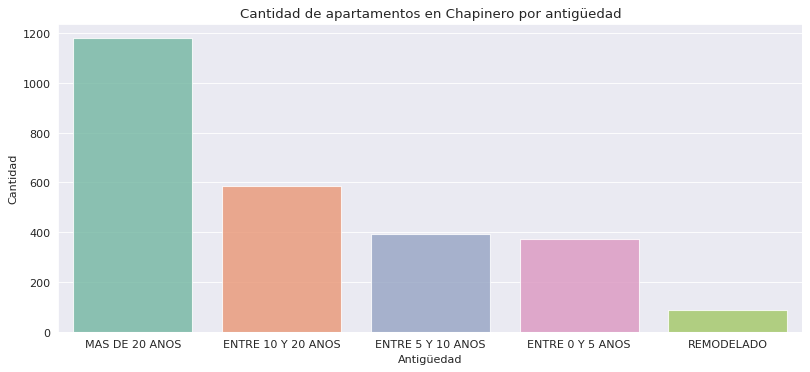

In [66]:
plt.figure(figsize=(12, 5))

sns.countplot(
    chapinero,
    x='antiguedad',
    order=chapinero.antiguedad.value_counts().index,
    palette='Set2',
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
)

plt.title('Cantidad de apartamentos en Chapinero por antigüedad')
plt.xlabel('Antigüedad')
plt.ylabel('Cantidad')
plt.show()

### Barrios

In [67]:
chapinero.groupby('antiguedad')['barrio'].describe()

count unique               top freq
antiguedad                                            
ENTRE 0 Y 5 ANOS     372     40  S.C. CHICO NORTE   45
ENTRE 10 Y 20 ANOS   586     53  S.C. CHICO NORTE   98
ENTRE 5 Y 10 ANOS    391     44  S.C. CHICO NORTE   49
MAS DE 20 ANOS      1179     57   S.C. BELLAVISTA  125
REMODELADO            88     23  S.C. CHICO NORTE   10

In [68]:
chapinero.groupby('antiguedad')['area'].describe().apply(lambda x: round(x,1))

count   mean    std   min    25%    50%    75%    max
antiguedad                                                                
ENTRE 0 Y 5 ANOS     372.0  138.3   83.3  17.4   64.8  134.5  193.2  404.0
ENTRE 10 Y 20 ANOS   586.0  185.3   89.8  21.0  113.5  176.0  241.8  450.0
ENTRE 5 Y 10 ANOS    391.0  170.5   89.6  24.0   98.0  157.0  231.0  445.0
MAS DE 20 ANOS      1179.0  198.9   92.0  30.0  127.9  187.0  259.0  445.0
REMODELADO            88.0  220.0  105.7  51.1  140.2  217.0  284.5  450.0

In [69]:
chapinero.groupby('barrio')['antiguedad'].describe().sort_values(by='count', ascending=False).head(10)

count unique                 top freq
barrio                                                           
S.C. CHICO NORTE              312      5      MAS DE 20 ANOS  110
LOS ROSALES                   238      5      MAS DE 20 ANOS  117
S.C. CHICO NORTE III SECTOR   233      5      MAS DE 20 ANOS  112
S.C. EL CHICO                 220      5      MAS DE 20 ANOS   74
S.C. BELLAVISTA               194      5      MAS DE 20 ANOS  125
LA CABRERA                    143      5      MAS DE 20 ANOS   57
EL REFUGIO                    115      5      MAS DE 20 ANOS   36
S.C. EL NOGAL                 113      5      MAS DE 20 ANOS   78
CHICO RESERVADO               105      4  ENTRE 10 Y 20 ANOS   40
S.C. LAS ACACIAS              102      5      MAS DE 20 ANOS   64

### Estrato

## Barrios

In [70]:
chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10)

codigo
barrio                             
S.C. CHICO NORTE                312
LOS ROSALES                     238
S.C. CHICO NORTE III SECTOR     233
S.C. EL CHICO                   220
S.C. BELLAVISTA                 195
LA CABRERA                      143
EL REFUGIO                      115
S.C. EL NOGAL                   113
CHICO RESERVADO                 105
S.C. LAS ACACIAS                102

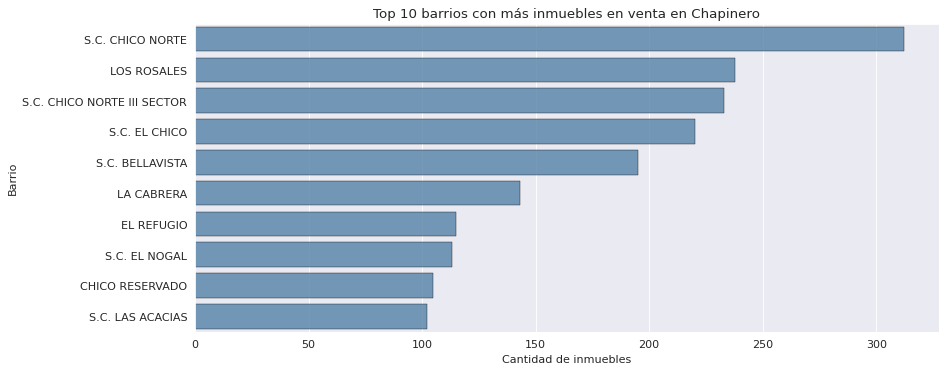

In [71]:
plt.figure(figsize=(12, 5))

sns.barplot(
    data=chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10),
    x='codigo',
    y=chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10).index,
    # palette='Set2',
    color='steelblue',
    orient='h',
    edgecolor='black',
    linewidth=.4,
    alpha=.8
)

plt.title('Top 10 barrios con más inmuebles en venta en Chapinero')
plt.xlabel('Cantidad de inmuebles')
plt.ylabel('Barrio')
plt.show()